In [3]:
import os

import pandas as pd
import numpy as np 
import torch
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint, EarlyStopping
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import cv2

In [4]:
#Открытый датасет
df = pd.read_csv("DataSets/full_df.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6392 entries, 0 to 6391
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   ID                         6392 non-null   int64 
 1   Patient Age                6392 non-null   int64 
 2   Patient Sex                6392 non-null   object
 3   Left-Fundus                6392 non-null   object
 4   Right-Fundus               6392 non-null   object
 5   Left-Diagnostic Keywords   6392 non-null   object
 6   Right-Diagnostic Keywords  6392 non-null   object
 7   N                          6392 non-null   int64 
 8   D                          6392 non-null   int64 
 9   G                          6392 non-null   int64 
 10  C                          6392 non-null   int64 
 11  A                          6392 non-null   int64 
 12  H                          6392 non-null   int64 
 13  M                          6392 non-null   int64 
 14  O       

Функции для определения заболевания (для метки)

In [5]:
left = list(df['Left-Diagnostic Keywords'].unique())
right = list(df['Right-Diagnostic Keywords'].unique())

diseases_list = []

for string in left:
    splitedstring = string.split('，')
    for value in splitedstring:
        if value not in diseases_list:
            diseases_list.append(value)

for string in right:
    splitedstring = string.split('，')
    for value in splitedstring:
        if value not in diseases_list:
            diseases_list.append(value)
    

In [6]:
print(diseases_list)
print(len(diseases_list))
    

['cataract', 'normal fundus', 'laser spot', 'moderate non proliferative retinopathy', 'macular epiretinal membrane', 'drusen', 'epiretinal membrane', 'hypertensive retinopathy', 'pathological myopia', 'mild nonproliferative retinopathy', 'macular hole', 'wet age-related macular degeneration', 'myelinated nerve fibers', 'dry age-related macular degeneration', 'diabetic retinopathy', 'lens dust', 'atrophy', 'white vessel', 'chorioretinal atrophy', 'retinitis pigmentosa', 'retina fold', 'suspected glaucoma', 'vitreous degeneration', 'branch retinal vein occlusion', 'retinal pigment epithelium atrophy', 'severe nonproliferative retinopathy', 'spotted membranous change', 'proliferative diabetic retinopathy', 'retinal pigmentation', 'glaucoma', 'refractive media opacity', 'severe proliferative diabetic retinopathy', 'epiretinal membrane over the macula', 'central retinal vein occlusion', 'depigmentation of the retinal pigment epithelium', 'suspected retinal vascular sheathing', 'maculopathy'

In [7]:
other_diseases = []
not_other_diseases = ['normal fundus', 
                     'moderate non proliferative retinopathy', 
                     'mild nonproliferative retinopathy', 
                     'severe nonproliferative retinopathy',
                     'glaucoma',
                     'cataract',
                     'dry age-related macular degeneration',
                     'wet age-related macular degeneration', 
                     'hypertensive retinopathy',
                     'pathological myopia']

for disease in diseases_list:
    if disease not in not_other_diseases:
        other_diseases.append(disease)

In [8]:
print(other_diseases)
print(len(other_diseases))

['laser spot', 'macular epiretinal membrane', 'drusen', 'epiretinal membrane', 'macular hole', 'myelinated nerve fibers', 'diabetic retinopathy', 'lens dust', 'atrophy', 'white vessel', 'chorioretinal atrophy', 'retinitis pigmentosa', 'retina fold', 'suspected glaucoma', 'vitreous degeneration', 'branch retinal vein occlusion', 'retinal pigment epithelium atrophy', 'spotted membranous change', 'proliferative diabetic retinopathy', 'retinal pigmentation', 'refractive media opacity', 'severe proliferative diabetic retinopathy', 'epiretinal membrane over the macula', 'central retinal vein occlusion', 'depigmentation of the retinal pigment epithelium', 'suspected retinal vascular sheathing', 'maculopathy', 'tessellated fundus', 'macular coloboma', 'vessel tortuosity', 'hypertensive retinopathy,diabetic retinopathy', 'optic nerve atrophy', 'wedge white line change', 'old choroiditis', 'myopic maculopathy', 'chorioretinal atrophy with pigmentation proliferation', 'pigment epithelium prolifer

In [9]:
# Для нормальных глаз
def is_normal(text):
    if 'normal fundus' in text:
        return 1
    else:
        return 0

# Для диабетиков
def is_diabetes(text):
    if ('moderate non proliferative retinopathy' or
        'mild nonproliferative retinopathy' or
        'severe nonproliferative retinopathy') in text:
        return 1
    else:
        return 0

# Для глаукомы (повышенное давление)
def is_glaucoma(text):
    if 'glaucoma' in text:
        return 1
    else:
        return 0

# Для катаракты
def is_cataract(text):
    if 'cataract' in text:
        return 1
    else:
        return 0

# Для возрастных 
def is_aged(text):
    if ('dry age-related macular degeneration' or
        'wet age-related macular degeneration') in text:
        return 1
    else:
        return 0

# Для гипертонии
def is_hypertension(text):
    if 'hypertensive retinopathy' in text:
        return 1
    else:
        return 0

# Для патологичемкой близорукости
def is_myopia(text):
    if 'pathological myopia' in text:
        return 1
    else:
        return 0
    
# Для патологичемкой близорукости
def is_other(text):
    for disease in other_diseases:
            if disease in text:
                return 1
    return 0

In [10]:
df["left_N"] = df["Left-Diagnostic Keywords"].apply(lambda x: is_normal(x))
df["right_N"] = df["Right-Diagnostic Keywords"].apply(lambda x: is_normal(x))

df["left_D"] = df["Left-Diagnostic Keywords"].apply(lambda x: is_diabetes(x))
df["right_D"] = df["Right-Diagnostic Keywords"].apply(lambda x: is_diabetes(x))

df["left_G"] = df["Left-Diagnostic Keywords"].apply(lambda x: is_glaucoma(x))
df["right_G"] = df["Right-Diagnostic Keywords"].apply(lambda x: is_glaucoma(x))

df["left_C"] = df["Left-Diagnostic Keywords"].apply(lambda x: is_cataract(x))
df["right_C"] = df["Right-Diagnostic Keywords"].apply(lambda x: is_cataract(x))

df["left_A"] = df["Left-Diagnostic Keywords"].apply(lambda x: is_aged(x))
df["right_A"] = df["Right-Diagnostic Keywords"].apply(lambda x: is_aged(x))

df["left_H"] = df["Left-Diagnostic Keywords"].apply(lambda x: is_hypertension(x))
df["right_H"] = df["Right-Diagnostic Keywords"].apply(lambda x: is_hypertension(x))

df["left_M"] = df["Left-Diagnostic Keywords"].apply(lambda x: is_myopia(x))
df["right_M"] = df["Right-Diagnostic Keywords"].apply(lambda x: is_myopia(x))

#df["left_O"] = df["Left-Diagnostic Keywords"].apply(lambda x: is_other(x))
#df["right_O"] = df["Right-Diagnostic Keywords"].apply(lambda x: is_other(x))

In [11]:
left_N = df.loc[(df.left_N == 1) & (df.N == 1)]["Left-Fundus"].values
right_N = df.loc[(df.right_N == 1) & (df.N == 1)]["Right-Fundus"].values

left_D = df.loc[(df.left_D == 1) & (df.D == 1)]["Left-Fundus"].values
right_D = df.loc[(df.right_D == 1) & (df.D == 1)]["Right-Fundus"].values

left_G = df.loc[(df.left_G == 1) & (df.G == 1)]["Left-Fundus"].values
right_G = df.loc[(df.right_G == 1) & (df.G == 1)]["Right-Fundus"].values

left_C = df.loc[(df.left_C == 1) & (df.C == 1)]["Left-Fundus"].values
right_C = df.loc[(df.right_C == 1) & (df.C == 1)]["Right-Fundus"].values

left_A = df.loc[(df.left_A == 1) & (df.A == 1)]["Left-Fundus"].values
right_A = df.loc[(df.right_A == 1) & (df.A == 1)]["Right-Fundus"].values

left_H = df.loc[(df.left_H == 1) & (df.H == 1)]["Left-Fundus"].values
right_H = df.loc[(df.right_H == 1) & (df.H == 1)]["Right-Fundus"].values

left_M = df.loc[(df.left_M == 1) & (df.M == 1)]["Left-Fundus"].values
right_M = df.loc[(df.right_M == 1) & (df.M == 1)]["Right-Fundus"].values

#left_O = df.loc[(df.left_O == 1) & (df.O == 1)]["Left-Fundus"].values
#right_O = df.loc[(df.right_O == 1) & (df.O == 1)]["Right-Fundus"].values

In [12]:
print(f"Количество изображений левый глаз - здоровый: {len(left_N)}")
print(f"Количество изображений правый глаз - здоровый: {len(right_N)} \n")

print(f"Количество изображений левый глаз - диабет: {len(left_D)}")
print(f"Количество изображений правый глаз - диабет: {len(right_D)} \n")

print(f"Количество изображений левый глаз - глаукома: {len(left_G)}")
print(f"Количество изображений правый глаз - глаукома: {len(right_G)} \n")

print(f"Количество изображений левый глаз - катаракта: {len(left_C)}")
print(f"Количество изображений правый глаз - катаракта: {len(right_C)} \n")

print(f"Количество изображений левый глаз - возрастное: {len(left_A)}")
print(f"Количество изображений правый глаз - возратстное: {len(right_A)} \n")

print(f"Количество изображений левый глаз - гипертензия: {len(left_H)}")
print(f"Количество изображений правый глаз - гипертензия: {len(right_H)} \n")

print(f"Количество изображений левый глаз - близорукость: {len(left_M)}")
print(f"Количество изображений правый глаз - близорукость: {len(right_M)} \n")

#print(f"Количество изображений левый глаз - другое заболевание: {len(left_O)}")
#print(f"Количество изображений правый глаз - другое заболевание: {len(right_O)}")

Количество изображений левый глаз - здоровый: 2100
Количество изображений правый глаз - здоровый: 2101 

Количество изображений левый глаз - диабет: 917
Количество изображений правый глаз - диабет: 960 

Количество изображений левый глаз - глаукома: 332
Количество изображений правый глаз - глаукома: 284 

Количество изображений левый глаз - катаракта: 304
Количество изображений правый глаз - катаракта: 290 

Количество изображений левый глаз - возрастное: 212
Количество изображений правый глаз - возратстное: 237 

Количество изображений левый глаз - гипертензия: 191
Количество изображений правый глаз - гипертензия: 191 

Количество изображений левый глаз - близорукость: 216
Количество изображений правый глаз - близорукость: 241 



In [13]:
left_N = df.loc[(df.left_N == 1) & (df.N == 1)]["Left-Fundus"].sample(250, random_state=100).values
right_N = df.loc[(df.right_N == 1) & (df.N == 1)]["Right-Fundus"].sample(250, random_state=100).values

left_D = df.loc[(df.left_D == 1) & (df.D == 1)]["Left-Fundus"].sample(250, random_state=100).values
right_D = df.loc[(df.right_D == 1) & (df.D == 1)]["Right-Fundus"].sample(250, random_state=100).values

#left_O = df.loc[(df.left_O == 1) & (df.O == 1)]["Left-Fundus"].sample(250, random_state=100).values
#right_O = df.loc[(df.right_O == 1) & (df.O == 1)]["Right-Fundus"].sample(250, random_state=100).values

In [14]:
print(f"Количество изображений левый глаз - здоровый: {len(left_N)}")
print(f"Количество изображений правый глаз - здоровый: {len(right_N)} \n")

print(f"Количество изображений левый глаз - диабет: {len(left_D)}")
print(f"Количество изображений правый глаз - диабет: {len(right_D)} \n")

#print(f"Количество изображений левый глаз - другое заболевание: {len(left_O)}")
#print(f"Количество изображений правый глаз - другое заболевание: {len(right_O)}")

Количество изображений левый глаз - здоровый: 250
Количество изображений правый глаз - здоровый: 250 

Количество изображений левый глаз - диабет: 250
Количество изображений правый глаз - диабет: 250 



In [15]:
normal = np.concatenate((left_N, right_N), axis=0)
diabetes = np.concatenate((left_D, right_D), axis=0)
glaucoma = np.concatenate((left_G, right_G), axis=0)
cataract = np.concatenate((left_C, right_C), axis=0)
aged = np.concatenate((left_A, right_A), axis=0)
hypertension = np.concatenate((left_H, right_H), axis=0)
myopia = np.concatenate((left_M, right_M), axis=0)
#others = np.concatenate((left_O, right_O), axis=0)

In [16]:
from tensorflow.keras.preprocessing.image import load_img,img_to_array
import random

dataset_folder = "DataSets/preprocessed_images"
image_size = 224
labels = []
dataset = []

def dataset_creation(image_class, lable):
    for img in tqdm(image_class):
        image_path = os.path.join(dataset_folder, img)
        try:
            image = cv2.imread(image_path, cv2.IMREAD_COLOR)
            image = cv2.resize(image, (image_size, image_size))
        except:
            continue
        
        dataset.append([np.array(image), np.array(lable)])

    random.shuffle(dataset)

    return dataset


In [17]:
dataset = dataset_creation(normal,0)
dataset = dataset_creation(diabetes,1)
dataset = dataset_creation(glaucoma,2)
dataset = dataset_creation(cataract,3)
dataset = dataset_creation(aged,4)
dataset = dataset_creation(hypertension,5)
dataset = dataset_creation(myopia,6)
#dataset = dataset_creation(others,7)

 31%|███       | 154/500 [00:00<00:01, 276.14it/s][ WARN:0@1.156] global loadsave.cpp:248 findDecoder imread_('DataSets/preprocessed_images/2737_left.jpg'): can't open/read file: check file path/integrity
[ WARN:0@1.194] global loadsave.cpp:248 findDecoder imread_('DataSets/preprocessed_images/2752_left.jpg'): can't open/read file: check file path/integrity
 66%|██████▌   | 328/500 [00:01<00:00, 273.56it/s][ WARN:0@1.782] global loadsave.cpp:248 findDecoder imread_('DataSets/preprocessed_images/2968_right.jpg'): can't open/read file: check file path/integrity
[ WARN:0@1.830] global loadsave.cpp:248 findDecoder imread_('DataSets/preprocessed_images/2428_right.jpg'): can't open/read file: check file path/integrity
  6%|▌         | 28/500 [00:00<00:01, 276.00it/s][ WARN:0@2.438] global loadsave.cpp:248 findDecoder imread_('DataSets/preprocessed_images/201_left.jpg'): can't open/read file: check file path/integrity
[ WARN:0@2.445] global loadsave.cpp:248 findDecoder imread_('DataSets/prepr

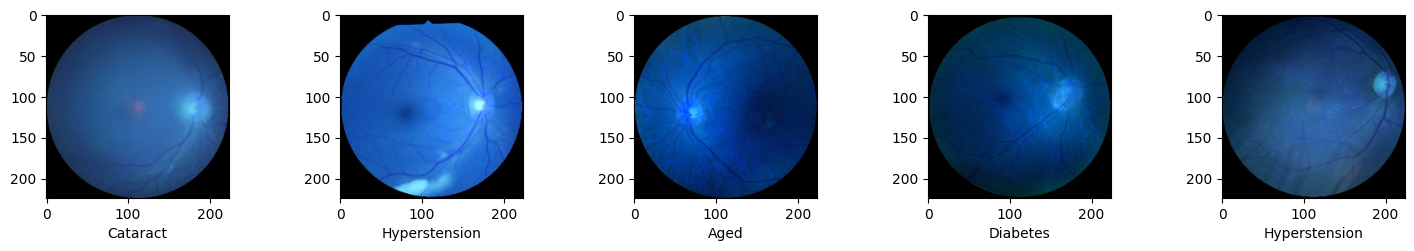

In [18]:
plt.figure(figsize=(15,7))
for i in range(5):
    sample = random.choice(range(len(dataset)))
    image = dataset[sample][0]
    category = dataset[sample][1]

    if category == 0:
        label = "Normal"
    elif category == 1:
        label = "Diabetes"
    elif category == 2:
        label = "Glaucoma"
    elif category == 3:
        label = "Cataract"
    elif category == 4:
        label = "Aged"
    elif category == 5:
        label = "Hyperstension"
    elif category == 6:
        label = "Myopia"
    else:
        label = "Other"

    plt.subplot(3, 5, i+1)

    plt.imshow(image)
    plt.xlabel(label)
plt.tight_layout()  

In [19]:
from keras.applications import EfficientNetB0
from keras import layers

mymodel = EfficientNetB0(weights = 'imagenet', include_top = False, input_shape = (image_size, image_size, 3))

for layer in mymodel.layers:
    layer.trainable = False

2024-03-06 02:16:32.070124: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-06 02:16:32.070296: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-06 02:16:32.070320: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-06 02:16:32.525884: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-06 02:16:32.526094: I external/local_xla/xla/stream_executor

In [20]:
from keras import Sequential
from keras.layers import Flatten,Dense


model = Sequential()
model.add(mymodel)
model.add(Flatten())
model.add(Dense(256,activation = "relu"))
model.add(tf.keras.layers.BatchNormalization())
model.add(Dense(256,activation = "relu"))
model.add(tf.keras.layers.BatchNormalization())
model.add(Dense(7,activation="softmax"))

In [21]:
from keras.optimizers import Adam
optimiz = Adam(learning_rate=1E-2)

In [22]:
x = np.array([i[0] for i in dataset]).reshape(-1,image_size,image_size,3)
y = np.array([i[1] for i in dataset])

x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2)

In [23]:
model.compile(optimizer=optimiz, loss='sparse_categorical_crossentropy', metrics=["accuracy"])

In [25]:
from keras.callbacks import ModelCheckpoint,EarlyStopping
checkpoint = ModelCheckpoint("model.h5",monitor="val_accuracy",verbose=1,save_best_only=True,
                             save_weights_only=False,period=1)
earlystop = EarlyStopping(monitor="val_accuracy",patience=5,verbose=1)

In [26]:
history = model.fit(x_train,y_train,
                    batch_size=32,
                    epochs=15,
                    validation_data=(x_test,y_test),
                    verbose=1,
                    callbacks=[checkpoint,earlystop])

Epoch 1/15


2024-03-06 02:16:44.715534: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-03-06 02:16:45.280710: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
2024-03-06 02:16:45.694888: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-03-06 02:16:48.438585: I external/local_xla/xla/service/service.cc:168] XLA service 0x55a428715170 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-06 02:16:48.438705: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Laptop GPU, Compute Capability 8.6
2024-03-06 02:16:48.457221: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1709680608.583901   71864 devic

87/87 [==============================] - ETA: 0s - loss: 1.4602 - accuracy: 0.4856
Epoch 1: val_accuracy improved from -inf to 0.33766, saving model to model.h5


/home/kot/.local/lib/python3.9/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


87/87 [==============================] - 24s 143ms/step - loss: 1.4602 - accuracy: 0.4856 - val_loss: 3.7543 - val_accuracy: 0.3377
Epoch 2/15
87/87 [==============================] - ETA: 0s - loss: 1.0481 - accuracy: 0.6183
Epoch 2: val_accuracy improved from 0.33766 to 0.48629, saving model to model.h5
87/87 [==============================] - 10s 116ms/step - loss: 1.0481 - accuracy: 0.6183 - val_loss: 1.8432 - val_accuracy: 0.4863
Epoch 3/15
87/87 [==============================] - ETA: 0s - loss: 0.8359 - accuracy: 0.7035
Epoch 3: val_accuracy improved from 0.48629 to 0.52092, saving model to model.h5
87/87 [==============================] - 9s 101ms/step - loss: 0.8359 - accuracy: 0.7035 - val_loss: 1.6268 - val_accuracy: 0.5209
Epoch 4/15
87/87 [==============================] - ETA: 0s - loss: 0.6994 - accuracy: 0.7511
Epoch 4: val_accuracy improved from 0.52092 to 0.67821, saving model to model.h5
87/87 [==============================] - 9s 101ms/step - loss: 0.6994 - accuracy

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


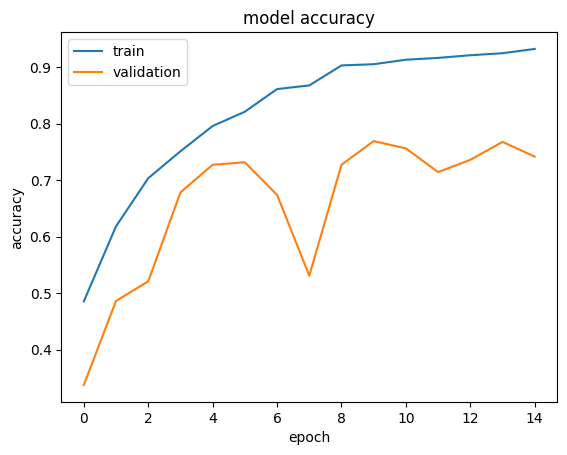

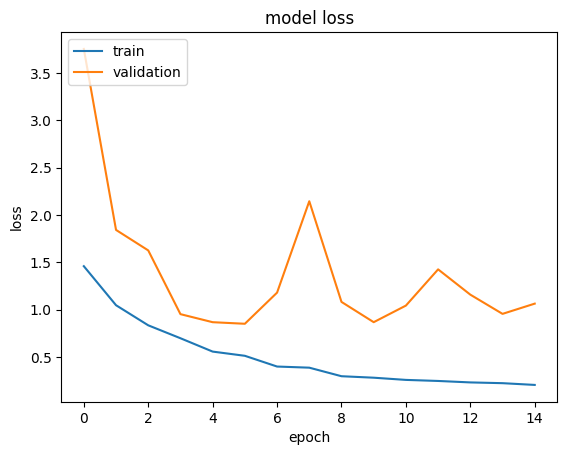

In [36]:
print(history.history.keys())
#  "Accuracy"
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()